### Import

In [1]:
from IPython.display import display, FileLink
from sklearn.metrics import (mean_absolute_error, confusion_matrix, log_loss,
                             precision_score, recall_score, f1_score)
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn import linear_model

import xgboost as xgb
import catboost as cb
import lightgbm as lgb
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.externals import joblib
from EricWang.utils_ew import *

### 1. Data Preparation

In [64]:
# NM = 'data/mdata/all_data_v0913_v2'
NM = 'data/mdata/all_data_v0906_v2'
all_Data = pd.read_feather(NM)

# 增加隨機欄
all_Data['random'] = np.random.random(size=len(all_Data))

# 欄位N_of_Claim有NaN
all_Data.fillna(0, inplace=True)

print(all_Data.shape); all_Data.head(2)

(351273, 469)


,Policy_Number,Next_Premium,Test_Flg,Insured's_ID,fassured,ibirth,dbirth,fsex,fmarriage,aassured_zip,...,Insured_Amount2_per_Customer,Insured_Amount3_per_Customer,Coverage_Deductible_if_applied_per_Customer,Replacement_cost_of_insured_vehicle_per_Customer,Premium_per_Customer_per_Customer,竊盜_flg,車損_flg,車責_flg,Classifer_flg,random
0,8e31b2f7864ddeac1be3a31766b0bf2c54908d37,4414,0,Pf463063087505010b011330565193eae3213beca,1,11/1980,11/1980,1,1,9ffd1ae121c4f26fe7f0c45ecdc85fa6ac245bf0,...,1.683382e+06,3.496723e+07,135.422373,467.921721,5870.499734,0,0,1,others,0.690683
1,3f9f289dd1b20494a2fe4b1f0fe2d78333c97eda,8236,0,Sd873f723d823d9109c82aa754ff26ae916822c5d,1,11/1956,03/1982,2,2,62362fbf882221470f099d8d0a119df93ce19831,...,1.683382e+06,3.496723e+07,135.422373,467.921721,5870.499734,1,1,1,others,0.218708


In [65]:
all_zero_check = pd.read_feather('data/mdata_v2/all_zero_check')

In [66]:
all_Data = all_Data.merge(all_zero_check, how = 'left', on = 'Policy_Number')
print(all_Data.shape); all_Data.head(2)

(351273, 473)


,Policy_Number,Next_Premium,Test_Flg,Insured's_ID,fassured,ibirth,dbirth,fsex,fmarriage,aassured_zip,...,Premium_per_Customer_per_Customer,竊盜_flg,車損_flg,車責_flg,Classifer_flg,random,sum_amt_all_zero_flg,sum_Deductible_less_zero_flg,amt_all_zero_ratio,Deductible_less_zero_ratio
0,8e31b2f7864ddeac1be3a31766b0bf2c54908d37,4414,0,Pf463063087505010b011330565193eae3213beca,1,11/1980,11/1980,1,1,9ffd1ae121c4f26fe7f0c45ecdc85fa6ac245bf0,...,5870.499734,0,0,1,others,0.690683,0,0,0.0,0.0
1,3f9f289dd1b20494a2fe4b1f0fe2d78333c97eda,8236,0,Sd873f723d823d9109c82aa754ff26ae916822c5d,1,11/1956,03/1982,2,2,62362fbf882221470f099d8d0a119df93ce19831,...,5870.499734,1,1,1,others,0.218708,0,0,0.0,0.0


In [67]:
# left_join target encoding
channel_infer = pd.read_feather('data/channel_infer')
zip_infer = pd.read_feather('data/zip_infer')
area_infer = pd.read_feather('data/area_infer')

channel_infer.shape, zip_infer.shape, area_infer.shape

((875, 2), (1722, 2), (22, 2))

In [68]:
all_Data = all_Data.merge(channel_infer, how = 'left', on = 'Distribution_Channel')
all_Data = all_Data.merge(zip_infer, how = 'left', on = 'aassured_zip')
all_Data = all_Data.merge(area_infer, how = 'left', on = 'iply_area')
print(all_Data.shape); all_Data.head(2)

(351273, 476)


,Policy_Number,Next_Premium,Test_Flg,Insured's_ID,fassured,ibirth,dbirth,fsex,fmarriage,aassured_zip,...,車責_flg,Classifer_flg,random,sum_amt_all_zero_flg,sum_Deductible_less_zero_flg,amt_all_zero_ratio,Deductible_less_zero_ratio,Distribution_Channel_te,aassured_zip_te,iply_area_te
0,8e31b2f7864ddeac1be3a31766b0bf2c54908d37,4414,0,Pf463063087505010b011330565193eae3213beca,1,11/1980,11/1980,1,1,9ffd1ae121c4f26fe7f0c45ecdc85fa6ac245bf0,...,1,others,0.690683,0,0,0.0,0.0,5513.196444,7304.979866,7100.439672
1,3f9f289dd1b20494a2fe4b1f0fe2d78333c97eda,8236,0,Sd873f723d823d9109c82aa754ff26ae916822c5d,1,11/1956,03/1982,2,2,62362fbf882221470f099d8d0a119df93ce19831,...,1,others,0.218708,0,0,0.0,0.0,5513.196444,5025.469444,5982.328117


In [69]:
# obj -> categorys
train_cats(all_Data)

In [70]:
# 類別轉數值 + 補missing值
ign = ['Classifer_flg', 'Test_Flg', 'Next_Premium'] #y跟切分tst的欄位不轉換
all_Data_v2, _, nas, _ = proc_df(all_Data, ignore_flds = ign, do_scale=True,max_n_cat=10)
all_Data_v2.head(2)

,Classifer_flg,Test_Flg,Next_Premium,Policy_Number,Insured's_ID,fassured,ibirth,dbirth,aassured_zip,iply_area,...,Imported_or_Domestic_Car_23,Imported_or_Domestic_Car_24,Imported_or_Domestic_Car_30,Imported_or_Domestic_Car_40,Imported_or_Domestic_Car_50,Imported_or_Domestic_Car_90,Imported_or_Domestic_Car_nan,Cancellation_,Cancellation_Y,Cancellation_nan
0,others,0,4414,195353,222720,-0.43703,822,845,1097,18,...,0,0,0,0,0,0,0,0,1,0
1,others,0,8236,87148,268871,-0.43703,798,222,646,19,...,0,0,0,0,0,0,0,1,0,0


In [71]:
# 切出trn, tst
trn = all_Data_v2[all_Data_v2.Test_Flg == '0'].drop(columns='Test_Flg')
tst = all_Data_v2[all_Data_v2.Test_Flg == '1'].drop(columns='Test_Flg')

print(trn.shape, tst.shape); trn.head(2)

(210763, 495) (140510, 495)


,Classifer_flg,Next_Premium,Policy_Number,Insured's_ID,fassured,ibirth,dbirth,aassured_zip,iply_area,ins_year,...,Imported_or_Domestic_Car_23,Imported_or_Domestic_Car_24,Imported_or_Domestic_Car_30,Imported_or_Domestic_Car_40,Imported_or_Domestic_Car_50,Imported_or_Domestic_Car_90,Imported_or_Domestic_Car_nan,Cancellation_,Cancellation_Y,Cancellation_nan
0,others,4414,195353,222720,-0.43703,822,845,1097,18,0.454325,...,0,0,0,0,0,0,0,0,1,0
1,others,8236,87148,268871,-0.43703,798,222,646,19,0.421079,...,0,0,0,0,0,0,0,1,0,0


In [72]:
# tst切分X
y_col = ['Classifer_flg', 'Next_Premium']
X_tst = tst.drop(columns=y_col)

In [73]:
# trn切分X, y
y_col = ['Classifer_flg', 'Next_Premium']
X_trn = trn.drop(columns=y_col)
y_trn = trn[y_col]

print(trn.shape, X_trn.shape, y_trn.shape); y_trn.head(2)

(210763, 495) (210763, 493) (210763, 2)


,Classifer_flg,Next_Premium
0,others,4414
1,others,8236


In [74]:
# y_trn: log1p_y, zero_flg, top_flg
y_trn['Next_Premium_Log1p'] = y_trn.Next_Premium.apply(lambda x:np.log1p(x))
y_trn['zero_flg'] = y_trn.Classifer_flg.apply(lambda x: 0 if x == 'others' else 1)
y_trn['top_flg'] = y_trn.Next_Premium.apply(lambda x: 1 if x >= 20000 else 0)
print(y_trn.shape); y_trn.tail()

(210763, 5)


/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

,Classifer_flg,Next_Premium,Next_Premium_Log1p,zero_flg,top_flg
210758,續約金額為零,0,0.000000,1,0
210759,others,8665,9.067163,0,0
210760,others,12741,9.452659,0,0
210761,others,3029,8.016318,0,0
210762,others,5167,8.550241,0,0


In [75]:
print(X_trn.shape, y_trn.shape, X_tst.shape)

(210763, 493) (210763, 5) (140510, 493)


In [76]:
X_tst.reset_index(drop = True, inplace = True)

In [18]:
# X_trn.to_feather('data/mdata/X_trn_0913_v2')
# y_trn.to_feather('data/mdata/y_trn_0913_v2')
# X_tst.to_feather('data/mdata/X_tst_0913_v2')

# X_trn = pd.read_feather('data/mdata/X_trn_0913_v2')
# y_trn = pd.read_feather('data/mdata/y_trn_0913_v2')
# X_tst = pd.read_feather('data/mdata/X_tst_0913_v2')

In [19]:
X_trn.head(2)

,Policy_Number,Insured's_ID,fassured,ibirth,dbirth,aassured_zip,iply_area,ins_year,ins_mon,age,...,Imported_or_Domestic_Car_23,Imported_or_Domestic_Car_24,Imported_or_Domestic_Car_30,Imported_or_Domestic_Car_40,Imported_or_Domestic_Car_50,Imported_or_Domestic_Car_90,Imported_or_Domestic_Car_nan,Cancellation_,Cancellation_Y,Cancellation_nan
0,195353,222720,-0.43703,822,845,1097,18,0.454325,1.343798,-0.23258,...,0,0,0,0,0,0,0,0,1,0
1,87148,268871,-0.43703,798,222,646,19,0.421079,1.343798,0.93208,...,0,0,0,0,0,0,0,1,0,0


In [20]:
X_trn.shape

(210763, 489)

### 2. Train/Valid(Hold-out)

In [110]:
X_train, X_valid, y_train, y_valid = train_test_split(X_trn, y_trn, 
                                                      test_size=0.3, random_state=42)

In [111]:
print(y_train.shape, y_valid.shape)

(147534, 5) (63229, 5)


### 3. Zero-Classifer

In [26]:
X_train.shape, X_valid.shape, y_train.zero_flg.shape, y_valid.zero_flg.shape

((147534, 489), (63229, 489), (147534,), (63229,))

#### Bagging - 3CV (LightGBM)

In [41]:
# set cv
n_splits = 3
cv = KFold(n_splits = n_splits, shuffle = True, random_state = 42) # random_state也可以當作hyper-para

In [42]:
# set model paras
lgb_param = {
    'objective' :'binary', #binary log loss classification
    'learning_rate' : 0.005,
    'num_leaves' : 126,
    'max_depth': 8,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'n_jobs' : -1
}

In [43]:
oof_train = np.zeros((X_train.shape[0],))
oof_imp = pd.DataFrame(index=X_train.columns)
oof_score = np.empty((n_splits, 1)) # 3 x 1

In [44]:
for i, (fit_idx, val_idx) in enumerate(cv.split(X_train, y_train)):        
    train_data=lgb.Dataset(X_train.iloc[fit_idx], label=y_train.zero_flg.iloc[fit_idx])
    valid_data=lgb.Dataset(X_train.iloc[val_idx], label=y_train.zero_flg.iloc[val_idx])

    # Train model on selected parameters and number of iterations
    lgb_zero_c = lgb.train(params = lgb_param, 
                           train_set = train_data,
                           valid_sets = valid_data,
                           num_boost_round = 10000,
                           early_stopping_rounds = 100,
                           verbose_eval = 100
                          )
    
    # Save the oof_train
    oof_train[val_idx] = lgb_zero_c.predict(X_train.iloc[val_idx])
    
    # Save the score
    oof_score[i] = list(lgb_zero_c.best_score.values())[0].get('binary_logloss')
    print('Fold {} logloss: {}'.format(i+1, oof_score[i]))
    
    # Save the importances
    oof_imp[i] = lgb_zero_c.feature_importance()
    
    # Save the models
    path = 'model/lgb_zero_c_' + str(i) + '.txt'
    print('save model to : ', path)
    lgb_zero_c.save_model(path)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's binary_logloss: 0.474665
[200]	valid_0's binary_logloss: 0.455626
[300]	valid_0's binary_logloss: 0.446427
[400]	valid_0's binary_logloss: 0.441493
[500]	valid_0's binary_logloss: 0.438602
[600]	valid_0's binary_logloss: 0.43684
[700]	valid_0's binary_logloss: 0.435705
[800]	valid_0's binary_logloss: 0.434994
[900]	valid_0's binary_logloss: 0.434568
[1000]	valid_0's binary_logloss: 0.434268
[1100]	valid_0's binary_logloss: 0.434049
[1200]	valid_0's binary_logloss: 0.433849
[1300]	valid_0's binary_logloss: 0.433728
[1400]	valid_0's binary_logloss: 0.433654
[1500]	valid_0's binary_logloss: 0.433564
[1600]	valid_0's binary_logloss: 0.433544
[1700]	valid_0's binary_logloss: 0.433495
[1800]	valid_0's binary_logloss: 0.433434
[1900]	valid_0's binary_logloss: 0.433394
Early stopping, best iteration is:
[1890]	valid_0's binary_logloss: 0.433386
Fold 1 logloss: [0.43339]
save model to :  model/lgb_zero_c_0.txt
Traini

In [45]:
val_mean = np.mean(oof_score)
val_std = np.std(oof_score)

print('Local logloss: {} (±{})'.format(val_mean, val_std))

Local logloss: 0.43224325310431394 (±0.0012508975712081886)


###### get feedback

In [59]:
clf_feedback = X_train[['Policy_Number']]
clf_feedback = clf_feedback.merge(all_Data, left_index = True, right_index = True)
clf_feedback['oof_train'] = oof_train
clf_feedback['oof_train_ans'] = y_train.zero_flg
clf_feedback.head() 

,Policy_Number_x,Policy_Number_y,Next_Premium,Test_Flg,Insured's_ID,fassured,ibirth,dbirth,fsex,fmarriage,...,竊盜_flg,車損_flg,車責_flg,Classifer_flg,random,Distribution_Channel_te,aassured_zip_te,iply_area_te,oof_train,oof_train_ans
102386,158223,7301b46bfa666837d25c3877d65ea1e8b244f64a,29570,0,2545169bcd3f041e9d62972995c4f23cef333ceda,2,0,0,,,...,1,1,1,others,0.978558,6956.504990,7740.830533,6744.532461,0.119074,0
14700,328243,ef3577e8061fcdac6181a0b8bf6a973398d1a27e,0,0,V07748bc7e65c5e92b2052429fba3669f954b1733,1,12/1972,12/1972,1,1,...,0,0,1,續約金額為零,0.153021,5513.196444,6454.828668,6744.532461,0.109863,1
152117,155664,712241879f3b0d433ba437735bf7d950966b8a62,4822,0,208dab05bf98c7106247de295bf860affdc85a4b3,2,0,0,,,...,0,0,1,others,0.560675,6956.504990,6234.031693,6009.956670,0.110004,0
55339,6215,04757802f42a8a23fc51e49c1a7d7647f7bfedd2,15062,0,A5fe197aed1882b2f004efc7e76974e94f1e594ba,1,06/1981,06/1981,1,2,...,0,1,1,others,0.599662,6956.504990,6787.641886,8582.584053,0.313470,0
206449,2069,01766e6d52d25c02f0a49854032af73d1fb6ac2c,0,0,204161312df884c0f2a5e9b9a010dee7f4e5627d4,2,0,0,0,0,...,0,0,1,續約金額為零,0.400449,6546.747404,6525.541278,6745.864333,0.998064,1


In [68]:
clf_feedback['oof_train_guess'] = clf_feedback.oof_train.apply(lambda x: 1 if x >= 0.5 else 0)
clf_feedback.head()

,Policy_Number_x,Policy_Number_y,Next_Premium,Test_Flg,Insured's_ID,fassured,ibirth,dbirth,fsex,fmarriage,...,車損_flg,車責_flg,Classifer_flg,random,Distribution_Channel_te,aassured_zip_te,iply_area_te,oof_train,oof_train_ans,oof_train_guess
102386,158223,7301b46bfa666837d25c3877d65ea1e8b244f64a,29570,0,2545169bcd3f041e9d62972995c4f23cef333ceda,2,0,0,,,...,1,1,others,0.978558,6956.504990,7740.830533,6744.532461,0.119074,0,0
14700,328243,ef3577e8061fcdac6181a0b8bf6a973398d1a27e,0,0,V07748bc7e65c5e92b2052429fba3669f954b1733,1,12/1972,12/1972,1,1,...,0,1,續約金額為零,0.153021,5513.196444,6454.828668,6744.532461,0.109863,1,0
152117,155664,712241879f3b0d433ba437735bf7d950966b8a62,4822,0,208dab05bf98c7106247de295bf860affdc85a4b3,2,0,0,,,...,0,1,others,0.560675,6956.504990,6234.031693,6009.956670,0.110004,0,0
55339,6215,04757802f42a8a23fc51e49c1a7d7647f7bfedd2,15062,0,A5fe197aed1882b2f004efc7e76974e94f1e594ba,1,06/1981,06/1981,1,2,...,1,1,others,0.599662,6956.504990,6787.641886,8582.584053,0.313470,0,0
206449,2069,01766e6d52d25c02f0a49854032af73d1fb6ac2c,0,0,204161312df884c0f2a5e9b9a010dee7f4e5627d4,2,0,0,0,0,...,0,1,續約金額為零,0.400449,6546.747404,6525.541278,6745.864333,0.998064,1,1


In [72]:
flt_1 = (clf_feedback.oof_train_ans == 1)
flt_2 = (clf_feedback.oof_train_ans == 0)
flt_3 = (clf_feedback.oof_train_guess == 1)
flt_4 = (clf_feedback.oof_train_guess == 0)

In [80]:
clf_feedback.loc[(flt_1 & flt_3), 'CM'] = 'TP'
clf_feedback.loc[(flt_2 & flt_4), 'CM'] = 'TN'
clf_feedback.loc[(flt_2 & flt_3), 'CM'] = 'FP'
clf_feedback.loc[(flt_1 & flt_4), 'CM'] = 'FN'

In [83]:
display_all(clf_feedback.head(2))

,Policy_Number_x,Policy_Number_y,Next_Premium,Test_Flg,Insured's_ID,fassured,ibirth,dbirth,fsex,fmarriage,aassured_zip,iply_area,ins_year,ins_mon,age,di_equal,Vehicle_identifier,Vehicle_Make_and_Model1,Vehicle_Make_and_Model2,Manafactured_Year_and_Month,Engine_Displacement_(Cubic_Centimeter),Imported_or_Domestic_Car,Coding_of_Vehicle_Branding_&_Type,qpt,car_age,tax_1,tax_2,Cancellation,Replacement_cost_of_insured_vehicle,Distribution_Channel,Multiple_Products_with_TmNewa_(Yes_or_No?),lia_class,plia_acc,pdmg_acc,min_Insured_Amount1,max_Insured_Amount1,sum_Insured_Amount1,mean_Insured_Amount1,min_Insured_Amount2,max_Insured_Amount2,sum_Insured_Amount2,mean_Insured_Amount2,min_Insured_Amount3,max_Insured_Amount3,sum_Insured_Amount3,mean_Insured_Amount3,min_Coverage_Deductible_if_applied,max_Coverage_Deductible_if_applied,sum_Coverage_Deductible_if_applied,mean_Coverage_Deductible_if_applied,min_Premium_except_cancel,max_Premium_except_cancel,sum_Premium_except_cancel,mean_Premium_except_cancel,竊盜_max_Coverage_Deductible_if_applied,車損_max_Coverage_Deductible_if_applied,車責_max_Coverage_Deductible_if_applied,竊盜_mean_Coverage_Deductible_if_applied,車損_mean_Coverage_Deductible_if_applied,車責_mean_Coverage_Deductible_if_applied,竊盜_min_Coverage_Deductible_if_applied,車損_min_Coverage_Deductible_if_applied,車責_min_Coverage_Deductible_if_applied,竊盜_sum_Coverage_Deductible_if_applied,車損_sum_Coverage_Deductible_if_applied,車責_sum_Coverage_Deductible_if_applied,竊盜_max_Insured_Amount1,車損_max_Insured_Amount1,車責_max_Insured_Amount1,竊盜_mean_Insured_Amount1,車損_mean_Insured_Amount1,車責_mean_Insured_Amount1,竊盜_min_Insured_Amount1,車損_min_Insured_Amount1,車責_min_Insured_Amount1,竊盜_sum_Insured_Amount1,車損_sum_Insured_Amount1,車責_sum_Insured_Amount1,竊盜_max_Insured_Amount2,車損_max_Insured_Amount2,車責_max_Insured_Amount2,竊盜_mean_Insured_Amount2,車損_mean_Insured_Amount2,車責_mean_Insured_Amount2,竊盜_min_Insured_Amount2,車損_min_Insured_Amount2,車責_min_Insured_Amount2,竊盜_sum_Insured_Amount2,車損_sum_Insured_Amount2,車責_sum_Insured_Amount2,竊盜_max_Insured_Amount3,車損_max_Insured_Amount3,車責_max_Insured_Amount3,竊盜_mean_Insured_Amount3,車損_mean_Insured_Amount3,車責_mean_Insured_Amount3,竊盜_min_Insured_Amount3,車損_min_Insured_Amount3,車責_min_Insured_Amount3,竊盜_sum_Insured_Amount3,車損_sum_Insured_Amount3,車責_sum_Insured_Amount3,竊盜_max_Premium_except_cancel,車損_max_Premium_except_cancel,車責_max_Premium_except_cancel,竊盜_mean_Premium_except_cancel,車損_mean_Premium_except_cancel,車責_mean_Premium_except_cancel,竊盜_min_Premium_except_cancel,車損_min_Premium_except_cancel,車責_min_Premium_except_cancel,竊盜_sum_Premium_except_cancel,車損_sum_Premium_except_cancel,車責_sum_Premium_except_cancel,00I_Insured_Amount1,01A_Insured_Amount1,01J_Insured_Amount1,02K_Insured_Amount1,03L_Insured_Amount1,04M_Insured_Amount1,05E_Insured_Amount1,05N_Insured_Amount1,06F_Insured_Amount1,07P_Insured_Amount1,08H_Insured_Amount1,09@_Insured_Amount1,09I_Insured_Amount1,10A_Insured_Amount1,12L_Insured_Amount1,14E_Insured_Amount1,14N_Insured_Amount1,15F_Insured_Amount1,15O_Insured_Amount1,16G_Insured_Amount1,16P_Insured_Amount1,18@_Insured_Amount1,18I_Insured_Amount1,20B_Insured_Amount1,20K_Insured_Amount1,25G_Insured_Amount1,26H_Insured_Amount1,27I_Insured_Amount1,29B_Insured_Amount1,29K_Insured_Amount1,32N_Insured_Amount1,33F_Insured_Amount1,33O_Insured_Amount1,34P_Insured_Amount1,35H_Insured_Amount1,36I_Insured_Amount1,37J_Insured_Amount1,40M_Insured_Amount1,41E_Insured_Amount1,41N_Insured_Amount1,42F_Insured_Amount1,45@_Insured_Amount1,46A_Insured_Amount1,47B_Insured_Amount1,51O_Insured_Amount1,55J_Insured_Amount1,56B_Insured_Amount1,56K_Insured_Amount1,57C_Insured_Amount1,57L_Insured_Amount1,65K_Insured_Amount1,66C_Insured_Amount1,66L_Insured_Amount1,67D_Insured_Amount1,68E_Insured_Amount1,68N_Insured_Amount1,70G_Insured_Amount1,70P_Insured_Amount1,71H_Insured_Amount1,72@_Insured_Amount1,00I_Insured_Amount2,01A_Insured_Amount2,01J_Insured_Amount2,02K_Insured_Amount2,03L_Insured_Amount2,04M_Insured_Amount2,05E_Insured_Amount2,05N_Ins

In [89]:
clf_feedback[['Cancellation', 'CM', 'Policy_Number_y']].groupby(by=['Cancellation', 'CM']).count()

Policy_Number_y
Cancellation CM                 
             FN            26493
             FP              110
             TN           136802
             TP             6973
Y            FN             8506
             FP             1300
             TN            26341
             TP             4238

In [87]:
clf_feedback[['CM', 'Policy_Number_y']].groupby(by=['CM']).count()

,Policy_Number_y
CM,
FN,34999
FP,1410
TN,163143
TP,11211


In [10]:
feature_importances.columns = ['cv1', 'cv2', 'cv3']
feature_importances.sort_values(by = 'cv2', ascending=False)[:5]

,cv1,cv2,cv3
random,3781,4137,3508
Vehicle_identifier,3951,4125,3688
Insured's_ID,3889,3983,3522
Vehicle_Make_and_Model2,4157,3975,3712
Policy_Number,4223,3927,3577


#### Single (LightGBM)

In [119]:
# X_train_v2, X_valid_v2 = X_train, X_valid

In [125]:
# X_train['car_age'] = X_train_v2.Manafactured_Year_and_Month - X_train_v2.ins_year
# X_valid['car_age'] = X_valid_v2.Manafactured_Year_and_Month - X_valid_v2.ins_year

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [33]:
drop_cols = ['aassured_zip', 'Policy_Number', 'qpt', "Insured's_ID"]
drop_cols = ['random']

In [34]:
# parameters for LightGBMClassifier
param_ = {
    'objective' :'binary', #binary log loss classification
    'learning_rate' : 0.005,
    'num_leaves' : 126,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_jobs' : -1
}

train_data=lgb.Dataset(X_train.drop(columns = drop_cols), label=y_train.zero_flg)
valid_data=lgb.Dataset(X_valid.drop(columns = drop_cols), label=y_valid.zero_flg)

# Train model on selected parameters and number of iterations
lgb_zero_c = lgb.train(params = param_, 
                       train_set = train_data,
                       valid_sets = valid_data,
                       num_boost_round = 10000,
                       early_stopping_rounds = 50,
                       verbose_eval = 100
                      )

Training until validation scores don't improve for 50 rounds.
[100]	valid_0's binary_logloss: 0.460268
[200]	valid_0's binary_logloss: 0.45369
[300]	valid_0's binary_logloss: 0.450456
[400]	valid_0's binary_logloss: 0.448709
[500]	valid_0's binary_logloss: 0.447595
[600]	valid_0's binary_logloss: 0.446879
[700]	valid_0's binary_logloss: 0.446288
[800]	valid_0's binary_logloss: 0.445913
[900]	valid_0's binary_logloss: 0.445665
[1000]	valid_0's binary_logloss: 0.445431
[1100]	valid_0's binary_logloss: 0.4452
[1200]	valid_0's binary_logloss: 0.445094
[1300]	valid_0's binary_logloss: 0.444987
[1400]	valid_0's binary_logloss: 0.444855
[1500]	valid_0's binary_logloss: 0.444817
[1600]	valid_0's binary_logloss: 0.444708
[1700]	valid_0's binary_logloss: 0.444654
[1800]	valid_0's binary_logloss: 0.444631
[1900]	valid_0's binary_logloss: 0.444604
Early stopping, best iteration is:
[1881]	valid_0's binary_logloss: 0.444595


In [139]:
base_score = list(lgb_zero_c.best_score.values())[0].get('binary_logloss')
base_score

0.4303759977331278

In [9]:
# path = 'model/lgb_zero_c_v0904.txt'
# save model to file
# lgb_zero_c.save_model(path)

# load model to predict
# lgb_zero_c = lgb.Booster(model_file = path)

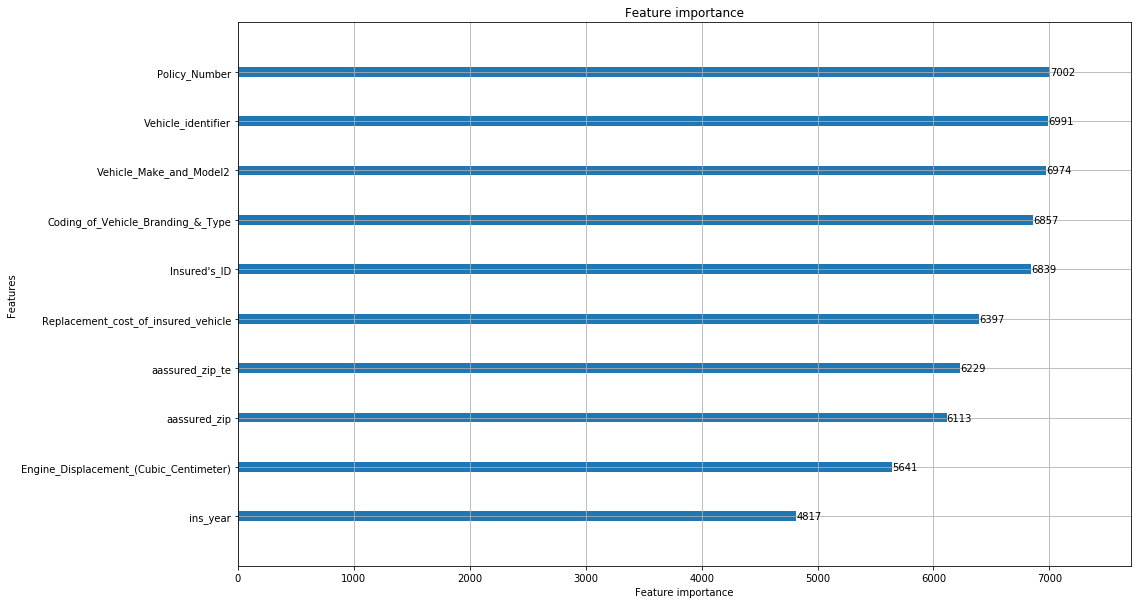

In [35]:
lgb.plot_importance(lgb_zero_c, max_num_features=10, figsize=(16,10))

In [36]:
# 預測機率值
zero_prob = lgb_zero_c.predict(X_valid.drop(columns = drop_cols))

In [42]:
zero_prd_flg = np.where(zero_prob >= 0.7, 1, 0)
zero_prd_flg.sum(), len(X_valid), np.round(zero_prd_flg.sum() / len(X_valid), 2)

(320, 60658, 0.01)

In [43]:
prd = zero_prd_flg
ans = y_valid.zero_flg

res = [f1_score(ans, prd), recall_score(ans, prd), precision_score(ans, prd)]
print(np.round(res, 2))

[0.04 0.02 0.8 ]


### 4.Regressor_NoZero

#### Re-Split Data

In [25]:
# sampling
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, 
#                                                       test_size=0.3, random_state=17)

In [26]:
# X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1474, 469), (633, 469), (1474, 5), (633, 5))

In [112]:
# trn set for regressor(no-zero)
reg_trn = pd.concat([y_train, X_train], axis = 1)
reg_trn = reg_trn[reg_trn.zero_flg == 0]

# split reg_trn_x/y
y_cols = y_train.columns.values
reg_trn_X = reg_trn.drop(columns=y_cols)
reg_trn_y = reg_trn[y_cols]

print(reg_trn_X.shape, reg_trn_y.shape)

(115072, 493) (115072, 5)


In [113]:
# val set for regressor(no-zero)
reg_val = pd.concat([y_valid, X_valid], axis = 1)
reg_val = reg_val[reg_val.zero_flg == 0]

# split val_trn_x/y
y_cols = y_valid.columns.values
reg_val_X = reg_val.drop(columns=y_cols)
reg_val_y = reg_val[y_cols]

print(reg_val_X.shape, reg_val_y.shape)

(49481, 493) (49481, 5)


In [114]:
reg_trn_X.head(2)

,Policy_Number,Insured's_ID,fassured,ibirth,dbirth,aassured_zip,iply_area,ins_year,ins_mon,age,...,Imported_or_Domestic_Car_23,Imported_or_Domestic_Car_24,Imported_or_Domestic_Car_30,Imported_or_Domestic_Car_40,Imported_or_Domestic_Car_50,Imported_or_Domestic_Car_90,Imported_or_Domestic_Car_nan,Cancellation_,Cancellation_Y,Cancellation_nan
143850,94503,11585,2.241259,1,662,408,3,-2.288404,-1.373592,-1.979569,...,0,0,0,0,0,0,0,1,0,0
8403,248763,145399,-0.437030,283,291,1216,21,0.447399,-0.385450,0.010058,...,0,0,0,0,0,0,0,1,0,0


In [116]:
i = 0
new_cols = []
while i < reg_trn_X.shape[1]:
    new_cols.append('X' + str(i))
    i = i + 1

In [117]:
_trn_X = reg_trn_X.copy()
_trn_X.columns = new_cols
_trn_X.head()

_trn_y = pd.DataFrame(reg_trn_y.Next_Premium)
_trn_y.columns = ['y']
_trn_y.head(2)

output_train = pd.concat([_trn_y, _trn_X], axis = 1)
output_train.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X483,X484,X485,X486,X487,X488,X489,X490,X491,X492
143850,3140,94503,11585,2.241259,1,662,408,3,-2.288404,-1.373592,...,0,0,0,0,0,0,0,1,0,0
8403,1758,248763,145399,-0.437030,283,291,1216,21,0.447399,-0.385450,...,0,0,0,0,0,0,0,1,0,0
131814,9609,18633,220899,-0.437030,882,908,888,18,0.428006,1.590834,...,0,0,1,0,0,0,0,1,0,0
172570,5506,26626,201146,-0.437030,862,888,295,15,0.400301,1.590834,...,0,0,0,0,0,0,0,1,0,0
90483,5956,218031,98903,-0.437030,40,40,1331,18,0.425235,-1.126556,...,0,0,0,0,0,0,0,1,0,0


In [118]:
output_train.to_csv('train_reg.csv', index=False)

In [119]:
_val_X = reg_val_X.copy()
_val_X.columns = new_cols
_val_X.head()

_val_y = pd.DataFrame(reg_val_y.Next_Premium)
_val_y.columns = ['y']
_val_y.head(2)

output_valid = pd.concat([_val_y, _val_X], axis = 1)
output_valid.head()

,y,X0,X1,X2,X3,X4,X5,X6,X7,X8,...,X483,X484,X485,X486,X487,X488,X489,X490,X491,X492
102968,32912,283937,9995,2.241259,1,1,1233,11,-2.288404,-1.373592,...,0,0,1,0,0,0,0,1,0,0
60746,4374,143502,222297,-0.437030,494,504,1097,18,0.422465,0.355656,...,0,0,0,0,0,0,0,1,0,0
13218,3777,67067,282934,-0.437030,359,130,1044,18,0.443243,-0.138414,...,0,0,0,0,0,0,0,1,0,0
172484,7021,112651,166021,-0.437030,577,587,879,11,0.430776,0.602692,...,0,0,0,0,0,0,0,1,0,0
71965,223,276951,39251,-0.437030,714,729,694,5,0.414153,1.096763,...,0,0,0,0,0,0,0,1,0,0


In [120]:
output_valid.to_csv('test_reg.csv', index=False)

In [121]:
!head -2 'test_reg.csv'

y,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,X64,X65,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75,X76,X77,X78,X79,X80,X81,X82,X83,X84,X85,X86,X87,X88,X89,X90,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100,X101,X102,X103,X104,X105,X106,X107,X108,X109,X110,X111,X112,X113,X114,X115,X116,X117,X118,X119,X120,X121,X122,X123,X124,X125,X126,X127,X128,X129,X130,X131,X132,X133,X134,X135,X136,X137,X138,X139,X140,X141,X142,X143,X144,X145,X146,X147,X148,X149,X150,X151,X152,X153,X154,X155,X156,X157,X158,X159,X160,X161,X162,X163,X164,X165,X166,X167,X168,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178,X179,X180,X181,X182,X183,X184,X185,X186,X187,X188,X189,X190,X191,X192,X193,X194,X195,X196,X197,X198,X199,X200,X201,X202,X203,X204,X205,X206,X207,X208,X209,X210,X211,X212,X213,X214,X215,X216,X217,X218,X219,X220,X22

#### Base Learner - 3CV (LightGBM) - Log

In [49]:
# 自定義log(Next_Premium)的eval
def log_error(preds, train_data):
    train_data=np.exp(train_data.get_label())-1
    preds=np.exp(preds)-1
    return 'error',mean_absolute_error(preds,train_data) , False

In [50]:
n_splits = 3
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
val_scores = [0] * n_splits

In [51]:
reg_trn_X = X_trn
reg_trn_y = y_trn

In [53]:
reg_imp = pd.DataFrame(index=reg_trn_X.columns)
oof_train = np.zeros((reg_trn_X.shape[0],))

param_={
    'boosting_type': 'gbdt',
    'learning_rate' : 0.005,
    'num_leaves' : 126,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_jobs': -1,
    'random_state': 42,
    'objective': 'mae'
}

for i, (fit_idx, val_idx) in enumerate(cv.split(reg_trn_X, reg_trn_y)):    
    train_data=lgb.Dataset(reg_trn_X.iloc[fit_idx], label=reg_trn_y.Next_Premium_Log1p.iloc[fit_idx])
    valid_data=lgb.Dataset(reg_trn_X.iloc[val_idx], label=reg_trn_y.Next_Premium_Log1p.iloc[val_idx])

    # Train model on selected parameters and number of iterations
    lgbm_log1p = lgb.train(params = param_, 
                           train_set = train_data,
                           valid_sets = valid_data,
                           feval = log_error,
                           num_boost_round = 10000,
                           early_stopping_rounds = 100,
                           verbose_eval = 100
                          )
    
    # Save the score
    val_scores[i] = list(lgbm_log1p.best_score.values())[0].get('error')
    print('Fold {} MAE: {:.5f}'.format(i+1, val_scores[i]))
    
    # Save oof
    oof_train[val_idx] = np.expm1(lgbm_log1p.predict(reg_trn_X.iloc[val_idx]))
    
    # Save the importances
    reg_imp[i] = lgbm_log1p.feature_importance()
    
    # Save the models
    path = 'model/lgbm_log1p_' + str(i) + '.txt'
    # Save model to file
    print('save model to : ', path)
    lgbm_log1p.save_model(path)

val_mean = np.mean(val_scores)
val_std = np.std(val_scores)

print('Local MAE: {:.5f} (±{:.5f})'.format(val_mean, val_std))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 1.85869	valid_0's error: 3237.55
[200]	valid_0's l1: 1.76257	valid_0's error: 2860.7
[300]	valid_0's l1: 1.70214	valid_0's error: 2574.6
[400]	valid_0's l1: 1.66473	valid_0's error: 2361.34
[500]	valid_0's l1: 1.63954	valid_0's error: 2198.8
[600]	valid_0's l1: 1.62166	valid_0's error: 2076.89
[700]	valid_0's l1: 1.6088	valid_0's error: 1990.94
[800]	valid_0's l1: 1.60066	valid_0's error: 1929.62
[900]	valid_0's l1: 1.59606	valid_0's error: 1888.58
[1000]	valid_0's l1: 1.59318	valid_0's error: 1859.89
[1100]	valid_0's l1: 1.59107	valid_0's error: 1841.41
[1200]	valid_0's l1: 1.58921	valid_0's error: 1830.27
[1300]	valid_0's l1: 1.58793	valid_0's error: 1823.46
[1400]	valid_0's l1: 1.58707	valid_0's error: 1818.36
[1500]	valid_0's l1: 1.58627	valid_0's error: 1815.02
[1600]	valid_0's l1: 1.58595	valid_0's error: 1812.86
[1700]	valid_0's l1: 1.58552	valid_0's error: 1811.7
[1800]	valid_0's l1: 1.58519	vali

In [64]:
oof_train

array([28683.15873,  4296.75564,  3790.7768 , ...,  4995.45317,  3896.61156,  2481.90785])

In [65]:
oof_train.shape

(164553,)

#### Base Learner - 3CV (LightGBM) - Premium

In [71]:
n_splits = 3
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
x_val_scores = [0] * n_splits

In [ ]:
x_reg_imp = pd.DataFrame(index=reg_trn_X.columns)
x_oof_train = np.zeros((reg_trn_X.shape[0],))

param_={
    'boosting_type': 'gbdt',
    'learning_rate' : 0.005,
    'num_leaves' : 63,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_jobs': -1,
    'random_state': 42,
    'objective': 'mae'
}

for i, (fit_idx, val_idx) in enumerate(cv.split(reg_trn_X, reg_trn_y)):    
    train_data=lgb.Dataset(reg_trn_X.iloc[fit_idx], label=reg_trn_y.Next_Premium.iloc[fit_idx])
    valid_data=lgb.Dataset(reg_trn_X.iloc[val_idx], label=reg_trn_y.Next_Premium.iloc[val_idx])

    # Train model on selected parameters and number of iterations
    lgbm_p = lgb.train(params = param_, 
                           train_set = train_data,
                           valid_sets = valid_data,
                           num_boost_round = 10000,
                           early_stopping_rounds = 100,
                           verbose_eval = 100
                          )
    
    # Save the score
    x_val_scores[i] = list(lgbm_p.best_score.values())[0].get('l1')
    print('Fold {} MAE: {:.5f}'.format(i+1, x_val_scores[i]))
    
    # Save oof
    x_oof_train[val_idx] = np.expm1(lgbm_lp.predict(reg_trn_X.iloc[val_idx]))
    
    # Save the importances
    x_reg_imp[i] = lgbm_p.feature_importance()
    
    # Save the models
    path = 'model/lgbm_p_' + str(i) + '.txt'
    # Save model to file
    print('save model to : ', path)
    lgbm_p.save_model(path)

val_mean = np.mean(x_val_scores)
val_std = np.std(x_val_scores)

print('Local MAE: {:.5f} (±{:.5f})'.format(val_mean, val_std))

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 2810.29
[200]	valid_0's l1: 2156.93
[300]	valid_0's l1: 1714.77
[400]	valid_0's l1: 1412.31
[500]	valid_0's l1: 1221.98
[600]	valid_0's l1: 1095.29
[700]	valid_0's l1: 1017.03
[800]	valid_0's l1: 968.843
[900]	valid_0's l1: 939.966
[1000]	valid_0's l1: 923.792
[1100]	valid_0's l1: 910.817
[1200]	valid_0's l1: 902.579
[1300]	valid_0's l1: 896.531
[1400]	valid_0's l1: 891.578
[1500]	valid_0's l1: 887.315
[1600]	valid_0's l1: 884.252
[1700]	valid_0's l1: 882.13
[1800]	valid_0's l1: 880.659
[1900]	valid_0's l1: 879.604
[2000]	valid_0's l1: 878.583
[2100]	valid_0's l1: 877.867
[2200]	valid_0's l1: 877.117
[2300]	valid_0's l1: 876.52
[2400]	valid_0's l1: 875.873
[2500]	valid_0's l1: 875.259
[2600]	valid_0's l1: 874.741
[2700]	valid_0's l1: 874.295
[2800]	valid_0's l1: 873.906
[2900]	valid_0's l1: 873.506
[3000]	valid_0's l1: 873.165
[3100]	valid_0's l1: 872.859
[3200]	valid_0's l1: 872.558
[3300]	valid_0's l1:

In [77]:
x_oof_train

array([0., 0., 0., ..., 0., 0., 0.])

In [78]:
x_oof_train.shape

(164553,)

#### Single

In [46]:
param_={
    'boosting_type': 'gbdt',
    'learning_rate' : 0.005,
    'num_leaves' : 126,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
    'n_jobs': -1,
    'random_state': 42,
    'objective': 'mae'
}

train_data=lgb.Dataset(X_train.drop(columns = drop_cols), label = y_train.Next_Premium)
valid_data=lgb.Dataset(X_valid.drop(columns = drop_cols), label = y_valid.Next_Premium)
# valid_data=lgb.Dataset(X_valid, label = y_valid.Next_Premium_Log1p)

# Train model on selected parameters and number of iterations
lgbm_log1p = lgb.train(params = param_, 
                       train_set = train_data,
                       valid_sets = valid_data,
#                        feval = log_error,
                       num_boost_round = 10000,
                       early_stopping_rounds = 100,
                       verbose_eval = 100
                      )

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 3153.15
[200]	valid_0's l1: 2721.57
[300]	valid_0's l1: 2434.11
[400]	valid_0's l1: 2235.18
[500]	valid_0's l1: 2086.45
[600]	valid_0's l1: 1982.02
[700]	valid_0's l1: 1913.42
[800]	valid_0's l1: 1867.17
[900]	valid_0's l1: 1836.27
[1000]	valid_0's l1: 1816.71
[1100]	valid_0's l1: 1803.82
[1200]	valid_0's l1: 1796.36
[1300]	valid_0's l1: 1790.75
[1400]	valid_0's l1: 1786.09
[1500]	valid_0's l1: 1782.81
[1600]	valid_0's l1: 1780.67
[1700]	valid_0's l1: 1778.93
[1800]	valid_0's l1: 1777.95
[1900]	valid_0's l1: 1776.95
[2000]	valid_0's l1: 1776.52
[2100]	valid_0's l1: 1776.02
[2200]	valid_0's l1: 1775.62
Early stopping, best iteration is:
[2190]	valid_0's l1: 1775.59


In [161]:
param_={
    'boosting_type': 'gbdt',
    'learning_rate' : 0.005,
    'num_leaves' : 63,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'n_jobs': -1,
    'random_state': 42,
    'objective': 'mae'
}

train_data=lgb.Dataset(reg_trn_X, label = reg_trn_y.Next_Premium)
valid_data=lgb.Dataset(reg_val_X, label=reg_val_y.Next_Premium)
# valid_data=lgb.Dataset(X_valid, label = y_valid.Next_Premium_Log1p)

# Train model on selected parameters and number of iterations
lgbm_log1p = lgb.train(params = param_, 
                       train_set = train_data,
                       valid_sets = valid_data,
#                        feval = log_error,
                       num_boost_round = 10000,
                       early_stopping_rounds = 100,
                       verbose_eval = 100
                      )

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's l1: 2819.23
[200]	valid_0's l1: 2163.49
[300]	valid_0's l1: 1719.48
[400]	valid_0's l1: 1417.58
[500]	valid_0's l1: 1228.85
[600]	valid_0's l1: 1108.66
[700]	valid_0's l1: 1029.59
[800]	valid_0's l1: 980.15
[900]	valid_0's l1: 952.052
[1000]	valid_0's l1: 932.768
[1100]	valid_0's l1: 920.428
[1200]	valid_0's l1: 910.009
[1300]	valid_0's l1: 903.413
[1400]	valid_0's l1: 898.509
[1500]	valid_0's l1: 894.146
[1600]	valid_0's l1: 890.906
[1700]	valid_0's l1: 888.877
[1800]	valid_0's l1: 887.384
[1900]	valid_0's l1: 886.094
[2000]	valid_0's l1: 884.865
[2100]	valid_0's l1: 884.145
[2200]	valid_0's l1: 883.284
[2300]	valid_0's l1: 882.593
[2400]	valid_0's l1: 881.798
[2500]	valid_0's l1: 881.052
[2600]	valid_0's l1: 880.456
[2700]	valid_0's l1: 879.925
[2800]	valid_0's l1: 879.52
[2900]	valid_0's l1: 879.035
[3000]	valid_0's l1: 878.495
[3100]	valid_0's l1: 877.948
[3200]	valid_0's l1: 877.467
[3300]	valid_0's l1:

In [100]:
# path = 'model/lgbm_log1p_v0904.txt'
# # save model to file
# lgbm_log1p.save_model(path)

# # load model to predict
# lgbm_log1p = lgb.Booster(model_file = path)

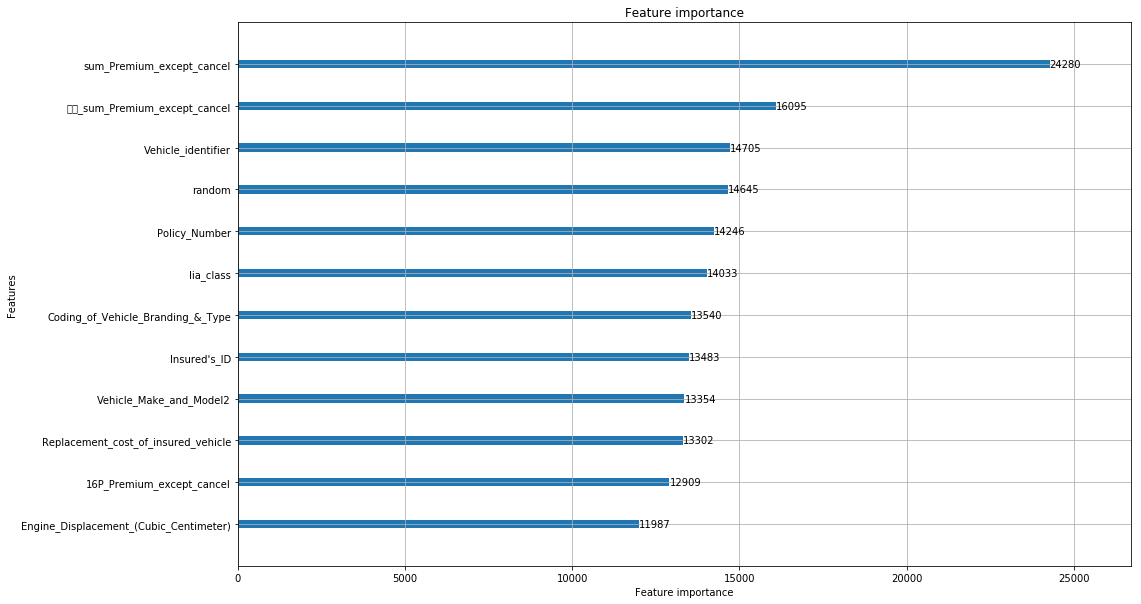

In [101]:
lgb.plot_importance(lgbm_log1p, max_num_features=12, figsize=(16,10))

### Loss Feedback (trn)

In [29]:
feedback_df = y_valid.drop(columns=['Classifer_flg'])

# 串聯flg機率
feedback_df['zero_prob'] = zero_prob
# feedback_df['top_prob'] = top_prob
feedback_df.head(2)

,Next_Premium,Next_Premium_Log1p,zero_flg,top_flg,zero_prob
102968,32912,10.401623,0,1,0.080463
60746,4374,8.383662,0,0,0.154418


In [30]:
# 串聯預測值
feedback_df['Next_p_no_zero'] = np.expm1(lgbm_log1p.predict(X_valid))
# feedback_df['Next_p_top'] = np.expm1(l_toplog1p.predict(X_valid))
feedback_df.head(2)

,Next_Premium,Next_Premium_Log1p,zero_flg,top_flg,zero_prob,Next_p_no_zero
102968,32912,10.401623,0,1,0.080463,28632.085998
60746,4374,8.383662,0,0,0.154418,4303.210041


In [39]:
# 情況1：zero_prob機率大於0.45時，Ans = 0, else Ans = Next_p_no_zero
feedback_df['Ans'] = feedback_df.Next_p_no_zero
feedback_df.loc[feedback_df.zero_prob >= 0.45, 'Ans'] = 0

feedback_df.Ans = feedback_df.Ans.apply(lambda x:round(x, 0))
print(mean_absolute_error(feedback_df.Next_Premium, feedback_df.Ans))
feedback_df.head(2)

1691.3669340924775


,Next_Premium,Next_Premium_Log1p,zero_flg,top_flg,zero_prob,Next_p_no_zero,Ans
102968,32912,10.401623,0,1,0.080463,28632.085998,28632.0
60746,4374,8.383662,0,0,0.154418,4303.210041,4303.0


In [229]:
# 情況2：zero_prob機率大於0.45時，Ans = 0, 
# elseif top_prob機率大於0.9時，Ans = Next_p_top
# else Ans = Next_p_no_zero

# feedback_df['Ans'] = feedback_df.Next_p_no_zero
# feedback_df.loc[feedback_df.zero_prob >= 0.45, 'Ans'] = 0
# feedback_df.loc[feedback_df.top_prob >= 0.9, 'Ans'] = feedback_df.Next_p_top

# feedback_df.Ans = feedback_df.Ans.apply(lambda x:round(x, 0))
# print(mean_absolute_error(feedback_df.Next_Premium, feedback_df.Ans))
# feedback_df.head(2)

1699.6543449505407


,Next_Premium,Next_Premium_Log1p,zero_flg,top_flg,zero_prob,top_prob,Next_p_no_zero,Next_p_top,Ans
102968,32912,10.401623,0,1,0.093090,0.834381,28761.932914,27993.758145,28762.0
60746,4374,8.383662,0,0,0.137892,0.000331,4353.599355,26297.558377,4354.0


看來做Top的這個想法不會比較好

### Testing

In [54]:
# X_tst = pd.read_feather('data/mdata/X_tst_0906')
X_tst.shape, X_trn.shape

((134997, 493), (202191, 493))

In [59]:
reg_trn_X.shape

(202191, 493)

In [55]:
sub = pd.read_csv('data/testing-set.csv')
sub.head(2)

,Policy_Number,Next_Premium
0,55789b8f86893761c9aa9e7bf17938e737decc68,100
1,b6df13a3384528ba6339c52b4fff7c149de68011,100


#### 3CV

In [57]:
lgbm_log1p_0 = lgb.Booster(model_file = 'model/lgbm_log1p_0.txt')
lgbm_log1p_1 = lgb.Booster(model_file = 'model/lgbm_log1p_1.txt')
lgbm_log1p_2 = lgb.Booster(model_file = 'model/lgbm_log1p_2.txt')

lgb_zero_c_0 = lgb.Booster(model_file = 'model/lgb_zero_c_0.txt')
lgb_zero_c_1 = lgb.Booster(model_file = 'model/lgb_zero_c_1.txt')
lgb_zero_c_2 = lgb.Booster(model_file = 'model/lgb_zero_c_2.txt')

In [77]:
sub['zero_prob_1'] = lgb_zero_c_0.predict(X_tst)
sub['zero_prob_2'] = lgb_zero_c_1.predict(X_tst)
sub['zero_prob_3'] = lgb_zero_c_2.predict(X_tst)

sub['Next_p_no_zero_0'] = np.expm1(lgbm_log1p_0.predict(X_tst))
sub['Next_p_no_zero_1'] = np.expm1(lgbm_log1p_1.predict(X_tst))
sub['Next_p_no_zero_2'] = np.expm1(lgbm_log1p_2.predict(X_tst))
# sub['sum_Premium_except_cancel'] = X_tst.sum_Premium_except_cancel

In [78]:
sub['zero_prob_avg'] = (sub.zero_prob_1 + sub.zero_prob_2 + sub.zero_prob_3) / 3
sub['Next_p_no_zero_Avg'] = (sub.Next_p_no_zero_0 + sub.Next_p_no_zero_1 + sub.Next_p_no_zero_2) / 3
sub.head()

,Policy_Number,Next_Premium,Next_p_no_zero_0,Next_p_no_zero_1,Next_p_no_zero_2,Next_p_no_zero_Avg
0,55789b8f86893761c9aa9e7bf17938e737decc68,100,3418.608303,3440.125722,3405.047140,3421.260388
1,b6df13a3384528ba6339c52b4fff7c149de68011,100,2021.572097,1883.177967,1950.901214,1951.883759
2,e112d926103147bcdcb6dab201b736185a3e2520,100,25.540668,5.273244,42.468185,24.427366
3,aa346fa4b1931d1c7a55f8e1bca40b0927dd65ac,100,6069.541918,6476.570685,6505.361569,6350.491390
4,39c4d5daaa791676ec5559c9066d7e8e8dfc51d7,100,3314.961245,3280.889163,3279.316070,3291.722159


In [79]:
map_y = pd.read_feather('data/mdata_v2/map_y')

In [81]:
map_y.head(2)

,Policy_Number,Next_Premium,Test_Flg,Next_Premium_Log1p
0,8e31b2f7864ddeac1be3a31766b0bf2c54908d37,4414.0,0,8.392763
1,3f9f289dd1b20494a2fe4b1f0fe2d78333c97eda,8236.0,0,9.016391


In [85]:
sub_X = sub.merge(map_y, on = 'Policy_Number')
sub_X['Final'] = sub_X.Next_Premium_y
sub_X.loc[sub_X.Next_Premium_y == -1, 'Final'] = sub_X.Next_p_no_zero_Avg

In [87]:
sub_go = sub_X[['Policy_Number', 'Final']]
sub_go.columns = ['Policy_Number', 'Next_Premium']

In [89]:
sub_go.Next_Premium  = sub_go.Next_Premium.apply(lambda x : int(x))
sub_go.head(2)

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,Policy_Number,Next_Premium
0,55789b8f86893761c9aa9e7bf17938e737decc68,3421
1,b6df13a3384528ba6339c52b4fff7c149de68011,1951


In [90]:
sub_go.loc[sub_go.Next_Premium <= 93, 'Next_Premium'] = 0

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [94]:
sub_go.head()

,Policy_Number,Next_Premium
0,55789b8f86893761c9aa9e7bf17938e737decc68,3421
1,b6df13a3384528ba6339c52b4fff7c149de68011,1951
2,e112d926103147bcdcb6dab201b736185a3e2520,0
3,aa346fa4b1931d1c7a55f8e1bca40b0927dd65ac,6350
4,39c4d5daaa791676ec5559c9066d7e8e8dfc51d7,3291


In [103]:
sub_go.loc[sub_go.Next_Premium.between(93, 183, inclusive=False), 'Next_Premium'] = 183

/home/ubuntu/src/anaconda3/envs/fastai/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [107]:
path = 'submission/clf_reg_3cv_v0914.csv'
sub_go.to_csv(path, index=False)
FileLink(path)

/home/ubuntu/EricWang/Premium_Prediction/submission/clf_reg_3cv_v0914.csv

In [105]:
sub_go.describe()

,Next_Premium
count,140510.000000
mean,4913.875418
std,5264.709665
min,0.000000
25%,2390.000000
50%,3410.000000
75%,5539.000000
max,87564.000000


#### Single

In [57]:
sub['zero_prob'] = lgb_zero_c.predict(X_tst)
sub['Next_p_no_zero'] = np.expm1(lgbm_log1p.predict(X_tst))
sub.head(2)

,Policy_Number,Next_Premium,zero_prob,Next_p_no_zero
0,55789b8f86893761c9aa9e7bf17938e737decc68,100,0.202862,3492.137556
1,b6df13a3384528ba6339c52b4fff7c149de68011,100,0.315021,2023.608056


In [58]:
# 情況1：zero_prob機率大於0.45時，Ans = 0, else Ans = Next_p_no_zero
sub['Next_Premium'] = sub.Next_p_no_zero
sub.loc[sub.zero_prob >= 0.45, 'Next_Premium'] = 0

sub.Next_Premium = sub.Next_Premium.apply(lambda x:round(x, 0))
sub.head(2)

,Policy_Number,Next_Premium,zero_prob,Next_p_no_zero
0,55789b8f86893761c9aa9e7bf17938e737decc68,3492.0,0.202862,3492.137556
1,b6df13a3384528ba6339c52b4fff7c149de68011,2024.0,0.315021,2023.608056


In [63]:
sub.Next_Premium = sub.Next_Premium.apply(lambda x: x*1.1 if x >= 31630.83 else x)

In [64]:
sub.Next_Premium.describe(percentiles=[0.8, 0.9, 0.95, 0.99])

count    140510.000000
mean       5240.958565
std        6201.965914
min           0.000000
50%        3582.000000
80%        6787.200000
90%       10291.000000
95%       15330.100000
99%       34509.342000
max      101847.900000
Name: Next_Premium, dtype: float64

In [39]:
sub.Next_Premium.describe()

count    140510.000000
mean       5197.707323
std        5998.591065
min           0.000000
25%        2477.000000
50%        3569.000000
75%        5752.000000
max      118523.000000
Name: Next_Premium, dtype: float64

In [65]:
sub_Final = sub[['Policy_Number', 'Next_Premium']]

path = 'submission/clf_reg_v0906_v3.csv'
sub_Final.to_csv(path, index=False)
FileLink(path)

/home/ubuntu/EricWang/Premium_Prediction/submission/clf_reg_v0906_v3.csv